In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import torch.optim as optim

In [2]:
good = None
ugly = None

with open('./dataset/good.npy', 'rb') as f:
    good = np.load(f)

with open('./dataset/ugly.npy', 'rb') as f:
    ugly = np.load(f)

In [40]:
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

class EmotionalArcDataset(Dataset):
    def __init__(self, good_arcs, ugly_arcs, p=100):
        self.good_arcs = good_arcs
        self.ugly_arcs = ugly_arcs
        self.n_good = good_arcs.shape[0]
        self.n_ugly = ugly_arcs.shape[0]
        self.p = p
        self.scaler = MinMaxScaler(feature_range=(-1, 1))  # Initialization of MinMaxScaler

    def __len__(self):
        return self.n_good + self.n_ugly

    def __getitem__(self, idx):
        if idx < self.n_good:
            sample = self.good_arcs[idx]
            label = 0  # Good
        else:
            sample = self.ugly_arcs[idx - self.n_good]
            label = 1  # Ugly
        
        # Randomly select a window from the time series
        window_size = int(len(sample) * self.p / 100)
        start_idx = np.random.randint(0, len(sample) - window_size + 1)
        sample = sample[start_idx : start_idx + window_size]

        # Normalize the sample with MinMaxScaler
        sample = self.scaler.fit_transform(sample.reshape(-1, 1))

        sample_tensor = torch.tensor(sample, dtype=torch.float32).reshape(window_size)
        return sample_tensor, label


Epoch [1/300], Loss: 0.6972, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [2/300], Loss: 0.7013, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [3/300], Loss: 0.7008, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [4/300], Loss: 0.7023, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [5/300], Loss: 0.7103, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [6/300], Loss: 0.6932, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [7/300], Loss: 0.6933, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [8/300], Loss: 0.7156, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [9/300], Loss: 0.7001, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [10/300], Loss: 0.6878, Train Accuracy: 51.39%, Val Accuracy: 46.91%
Epoch [11/300], Loss: 0.7232, Train Accuracy: 51.55%, Val Accuracy: 46.91%
Epoch [12/300], Loss: 0.6767, Train Accuracy: 51.24%, Val Accuracy: 46.91%
Epoch [13/300], Loss: 0.6813, Train Accuracy: 51.24%, Val Accuracy: 46.91%
Epoch [14/300], Loss: 0.6791, Trai

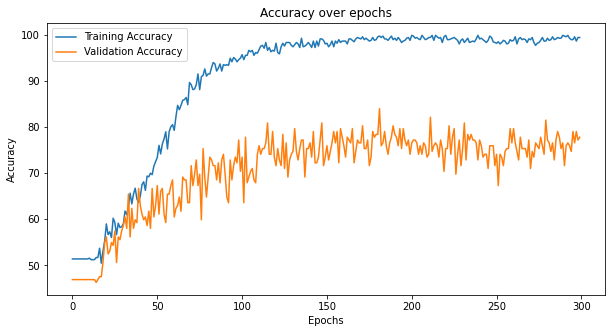

In [43]:
import matplotlib.pyplot as plt

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=False, dropout_p=0.5):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_p)
        
        if bidirectional:
            self.fc = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a batch dimension to the input
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out
# Create your numpy arrays (dummy data for the example)
# good_arcs = np.random.rand(100, 50)
# ugly_arcs = np.random.rand(100, 50)
p=80
# Create the dataset and split into train and validation sets
dataset = EmotionalArcDataset(good, ugly, p)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the LSTM model, loss function, and optimizer
input_size = int(5000*p/100)
hidden_size = 128
num_layers = 3
num_classes = 2
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 300

train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    train_accuracy.append(100 * correct_train / total_train)

    # Validate the model
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
    val_accuracy.append(100 * correct_val / total_val)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy[-1]:.2f}%, Val Accuracy: {val_accuracy[-1]:.2f}%")

# Plotting the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Lists to hold scores for each p value for plotting later
ps = []
best_eval_scores = []
corresponding_test_scores = []

# Loop over the range of p values
for p in range(100, 20, -20):
    best_eval_score = 0
    corresponding_test_score = 0

    print(p)

    num_epochs= 300 + int(100*(100-p)/100)
    # Preprocess the dataset
    dataset = EmotionalArcDataset(good, ugly, p)
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize the LSTM model, loss function, and optimizer
    input_size = int(5000 * p / 100)
    hidden_size = 128
    num_layers = 3
    num_classes = 2
    model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # Validate the model
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data, labels in val_loader:
                data = data.to(device)
                labels = labels.to(device)
                outputs = model(data)
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
        val_accuracy = 100 * correct_val / total_val

        if(epoch%50 ==0):
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        # If this epoch's validation score is better than the best one so far, save it,
        # and calculate and save the corresponding test score
        if val_accuracy > best_eval_score:
            best_eval_score = val_accuracy
            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for data, labels in test_loader:
                    data = data.to(device)
                    labels = labels.to(device)
                    outputs = model(data)
                    _, predicted_test = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted_test == labels).sum().item()
            corresponding_test_score = 100 * correct_test / total_test

        # After all epochs for this value of p, save the scores
        ps.append(p)
        best_eval_scores.append(best_eval_score)
        corresponding_test_scores.append(corresponding_test_score)

# Plot the scores
plt.figure(figsize=(10,6))
plt.plot(ps, best_eval_scores, label='Best Evaluation Scores')
plt.plot(ps, corresponding_test_scores, label='Corresponding Test Scores')
plt.xlabel('p value')
plt.ylabel('Score')
plt.title('Scores for Different Values of p')
plt.legend()
plt.show()

100
Epoch [1/300], Loss: 0.6428, Train Accuracy: 50.83%, Val Accuracy: 46.58%
Epoch [51/300], Loss: 0.0030, Train Accuracy: 100.00%, Val Accuracy: 70.19%
Epoch [101/300], Loss: 0.0011, Train Accuracy: 100.00%, Val Accuracy: 72.67%
Epoch [151/300], Loss: 0.0008, Train Accuracy: 100.00%, Val Accuracy: 72.05%
Epoch [201/300], Loss: 0.0000, Train Accuracy: 100.00%, Val Accuracy: 70.81%
Epoch [251/300], Loss: 0.0009, Train Accuracy: 100.00%, Val Accuracy: 71.43%
80
Epoch [1/320], Loss: 0.6960, Train Accuracy: 45.87%, Val Accuracy: 52.17%
Epoch [51/320], Loss: 0.2116, Train Accuracy: 77.07%, Val Accuracy: 53.42%
Epoch [101/320], Loss: 0.2715, Train Accuracy: 95.45%, Val Accuracy: 66.46%
Epoch [151/320], Loss: 0.0382, Train Accuracy: 98.76%, Val Accuracy: 68.32%
Epoch [201/320], Loss: 0.0016, Train Accuracy: 98.97%, Val Accuracy: 62.11%
Epoch [251/320], Loss: 0.0181, Train Accuracy: 99.17%, Val Accuracy: 69.57%
Epoch [301/320], Loss: 0.0007, Train Accuracy: 99.79%, Val Accuracy: 64.60%
60
Epo